In [53]:
import pandas as pd
import numpy as np
import cv2
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import os
% matplotlib inline

UsageError: Line magic function `%` not found.


In [21]:
meta_df = pd.read_csv('data/meta.csv')
train_df = pd.read_csv('data/food_tagging_train.csv')
test_df = pd.read_csv('data/food_tagging_test.csv')

/opt/anaconda3/envs/miranda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
print("Size of Meta ", meta_df.shape)
print("Size of train ", train_df.shape)
print("Size of test ", test_df.shape)

Size of Meta  (2215071, 8)
Size of train  (9916, 52)
Size of test  (2480, 4)


In [5]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215071 entries, 0 to 2215070
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           int64  
 1   photo             object 
 2   item_name         object 
 3   menu_name         object 
 4   item_price_amt    float64
 5   item_description  object 
 6   menu_active_flag  object 
 7   outlet_name       object 
dtypes: float64(1), int64(1), object(6)
memory usage: 135.2+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480 entries, 0 to 2479
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  2480 non-null   int64  
 1   photo    2480 non-null   object 
 2   name     2480 non-null   object 
 3   price    2480 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 77.6+ KB


### Merging the meta data to the training and test data

In [7]:
test_meta_df = pd.merge(test_df,meta_df,how='left',on=["item_id"])
train_meta_df = pd.merge(train_df,meta_df,how='left',on=["item_id"])

In [8]:
train_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9916 entries, 0 to 9915
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_id           9916 non-null   int64  
 1   photo_x           9916 non-null   object 
 2   name              9916 non-null   object 
 3   price             9916 non-null   float64
 4   Asian             9916 non-null   int64  
 5   Babi              9916 non-null   int64  
 6   Bakso             9916 non-null   int64  
 7   Bebek             9916 non-null   int64  
 8   Beverages         9916 non-null   int64  
 9   Boiled            9916 non-null   int64  
 10  Bubur             9916 non-null   int64  
 11  Burger            9916 non-null   int64  
 12  Cake_and_Bread    9916 non-null   int64  
 13  Chicken           9916 non-null   int64  
 14  Chinese           9916 non-null   int64  
 15  Coffee            9916 non-null   int64  
 16  Dessert_Sweet     9916 non-null   int64  


### Checking the number of values per class

In [44]:
count = {}
for index in range(4,52):
    column_name = list(train_meta_df.columns)[index]
    count[column_name] =  len(train_meta_df[train_meta_df[column_name]==1])

sorted_count = sorted(count, key=lambda x: count[x], reverse = True)
for key in sorted_count:
    print(f"{key}\t\t{count[key]}")

Indonesian		7643
Personal		6859
Main_Course		6683
Salty		5324
Chicken		2318
Rice		1893
Spicy		1264
Snack_Appetizer		1212
Sharing		1077
Dessert_Sweet		1068
Gorengan		797
Asian		787
Vegetable		718
Set_Menu		708
Grilled		703
Noodle		675
Western		575
Red_Meat		567
Boiled		544
Beverages		540
Martabak		433
Cake_and_Bread		407
Kukus		374
Soup		365
Bakso		354
Sauce		352
Chinese		340
Sate		308
Egg		278
Fish		267
Italian		241
Pizza		214
Japanese		199
Seafood		196
Tea		194
Organic		171
Pempek		159
Sour		159
Burger		150
Milk		131
Bubur		121
Bebek		115
Babi		107
Siomay		84
Middle_Eastern		83
Coffee		77
Fries		63
Gado2		34


#### Class imbalance problem exists. while most of the dishes are indonesian, there only 100's of data points for bottom 10 - 20 classes. need some method to handle class imbalance

### Checking if there is a difference in meta information and training data

In [10]:
train_meta_df[train_meta_df['photo_x']!=train_meta_df['photo_y']].head()

,item_id,photo_x,name,price,Asian,Babi,Bakso,Bebek,Beverages,Boiled,...,Tea,Vegetable,Western,photo_y,item_name,menu_name,item_price_amt,item_description,menu_active_flag,outlet_name
52,28291724,e8f6be79-636a-471b-bb25-8153558ef029.jpg,Bubblegum,20000.0,1,0,0,0,1,0,...,0,0,0,fbc7ba14-e96e-48ae-a942-5388a243e4e5.jpg,Bubblegum,Blended (Regular) -,20000.0,NaN,False,"Hop Hop, ITC Permata Hijau"
166,28421576,0859fa13-7bd1-43d0-a845-5b5d283a9e2d.jpg,Margherita,60000.0,0,0,0,0,0,0,...,0,0,0,d8f3ce4c-1aae-4040-8952-0149f6291610.jpg,Margherita,Classic Pizza,69000.0,"Mozzarella, tomato",True,"Pizza Marzano, Pondok Indah Mall 2"
178,34007185,7e3a3a52-0087-4a8e-a832-e120b54fec80.jpg,1/2 Keju - 1/2 Coklat Kacang Wijen,65000.0,0,0,0,0,0,0,...,0,0,0,df287179-c5a6-42d1-8a4a-8ffcfab947a7.jpg,1/2 Keju - 1/2 Coklat Kacang Wijen,Martabak Manis ( Original / Pandan ),65000.0,NaN,True,"Martabak 777 Sinar Bulan, Modernland"
188,35195643,d5fedcef-4b98-4f8f-90a5-395f67de3663.jpg,Paket Ayam Geprek,19000.0,0,0,0,0,0,0,...,0,0,0,faf1e948-22b6-4f5d-8cef-71c0c3e78b0c.jpg,Paket Geprek Bensu,Paket,19000.0,Nasi + Ayam Geprek Level 1-10,True,"Geprek Bensu, Cirendeu"
219,31333679,95a61ef7-b015-4748-b992-67cc27f0bc86.jpg,Chicken Karage,23000.0,0,0,0,0,0,0,...,0,0,0,3a30d428-fd13-408a-97b6-304cab8ce220.jpg,Chicken Karaage,Side Dish,25000.0,5 Pcs Ayam Goreng Dengan Bumbu Khas Jepang,False,"YOSHINOYA, Mall Kelapa Gading 3"


In [11]:
print("Data with difference in photo")
print(train_meta_df[train_meta_df['photo_x']!=train_meta_df['photo_y']].shape[0])
print("Data with difference in item name")
print(train_meta_df[train_meta_df['name']!=train_meta_df['item_name']].shape[0])

Data with difference in photo
253
Data with difference in item name
348


##### There is difference in Name and photo for some data between Meta Data and training data. giving training data preference.


In [12]:
print(train_meta_df['item_description'].isnull().sum()/train_meta_df.shape[0])

0.6928196853569988


In [13]:
train_meta_df['item_description'] = train_meta_df['item_description'].fillna('')

##### Since a lot of item description is not available (amost 70% unavailable), cannot use as a separate feature. but can augment the item_name with description when available to see if it increases the overall accuracy

In [9]:
train_meta_df.describe()

,item_id,price,Asian,Babi,Bakso,Bebek,Beverages,Boiled,Bubur,Burger,...,Sharing,Siomay,Snack_Appetizer,Soup,Sour,Spicy,Tea,Vegetable,Western,item_price_amt
count,9.916000e+03,9916.000000,9916.000000,9916.000000,9916.00000,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,...,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,9916.000000,9911.000000
mean,3.145964e+07,23436.323013,0.079367,0.010791,0.03570,0.011597,0.054457,0.054861,0.012203,0.015127,...,0.108612,0.008471,0.122227,0.036809,0.016035,0.127471,0.019564,0.072408,0.057987,23594.990112
std,2.499678e+06,21258.403405,0.270324,0.103321,0.18555,0.107070,0.226930,0.227720,0.109794,0.122064,...,0.311168,0.091653,0.327564,0.188303,0.125615,0.333516,0.138505,0.259176,0.233731,21496.018623
min,2.511210e+07,1000.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000
25%,2.996896e+07,10000.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10000.000000
50%,3.189475e+07,18000.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18600.000000
75%,3.334937e+07,29000.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29000.000000
max,3.676631e+07,350000.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,350000.000000


#### Price varies a lot from 1000 to 350000, need to check the distribution to see special handing is needed

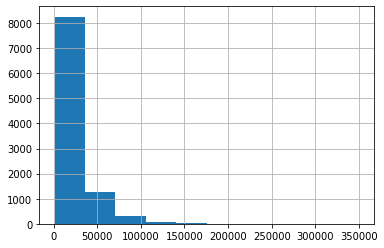

In [32]:
train_meta_df.price.hist()

#### Price is in a long tail distribution, performing log transformation to check if normal distribution can be obtained

In [33]:
train_meta_df['price_new'] = np.log2(train_meta_df['price'])

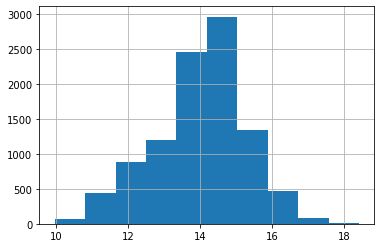

In [35]:
train_meta_df.price_new.hist()

### To see the words in Names that most affect the category

In [22]:
def load_stop_words():
    nltk.download('stopwords')
    with open("stopwords-id.txt") as fh:
        lines = fh.readlines()
        words = [l.strip() for l in lines]
    return words

stopwords_id = load_stop_words()

def preprocess(txt):
    txt = re.sub(r'\W+', ' ', txt)
    txt = txt.lower()
    txt = txt.replace("[^a-zA-Z]", " ")
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(txt)  
    filtered_words = [w for w in tokens if len(w) > 2 and w not in stopwords_id and w not in stopwords.words()]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santhosh.mohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


column name: Asian


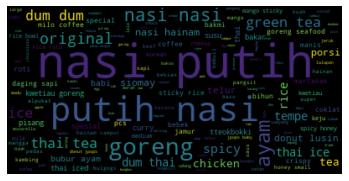

column name: Boiled


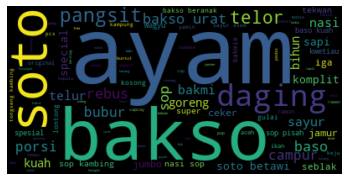

column name: Coffee


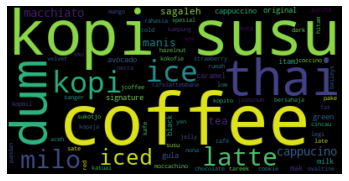

column name: Pizza


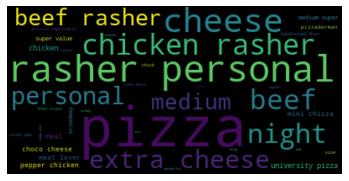

column name: Vegetable


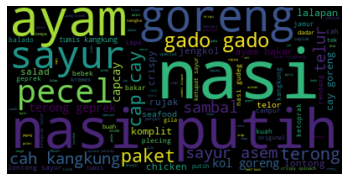

In [31]:
for index in [4,9,15,35, 50]:
    column_name = list(train_meta_df.columns)[index]
    print("column name:",column_name)
    df = train_meta_df[train_meta_df[column_name]==1]
    words = [preprocess(name) for name in list(df['name'])]
    words = " ".join(words).strip()
    wordcloud = WordCloud().generate(words)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### As we can see, some oclumns are clearly identifyable by name like coffee or pizza. but some are quite difficult. not so easy to distinguish between asian AND vegetable. 

## Image Samples

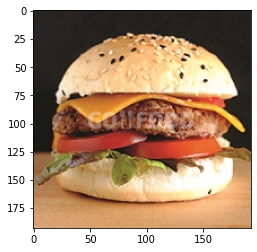

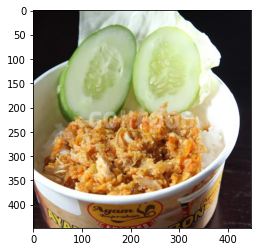

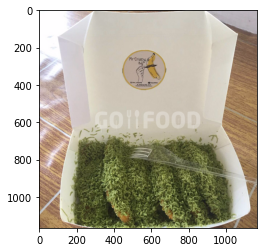

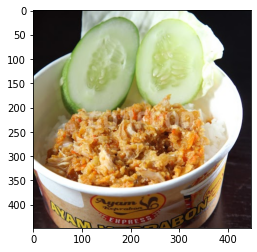

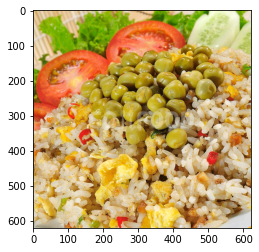

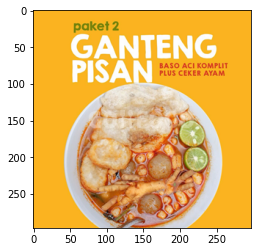

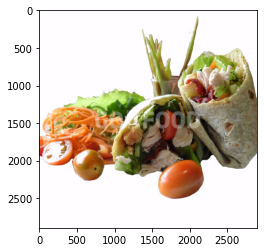

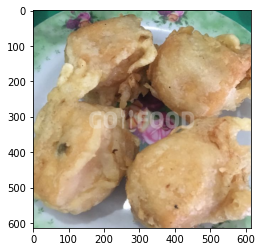

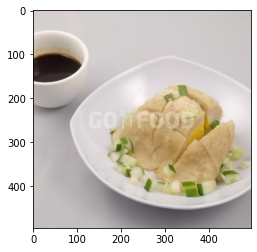

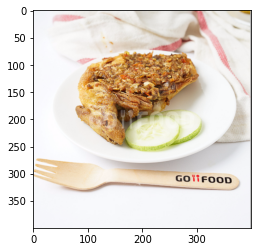

In [64]:
for _ in range(10):
    sample = train_meta_df.sample(n=1)
    image = f"imgs/{sample.iloc[0]['photo_x']}"
    if os.path.exists(image):
        plt.figure()
        image = Image.open(image)
        plt.imshow(image)
    else:
        print("path does not exists")    

#### Image are of varying size. some image are clean while others have water mark anf contain additional items in photo

### Computing class weights

In [5]:
import pandas as pd

tf = pd.read_csv("C:\\Users\\Mercedez\\Downloads\\santhosh\\food_item_tag\\data\\training_data.csv")
vf = pd.read_csv("C:\\Users\\Mercedez\\Downloads\\santhosh\\food_item_tag\\data\\validation_data.csv")
print(tf.shape)
print(vf.shape)

(7927, 55)
(1984, 55)


In [6]:
df = pd.concat([tf,vf], axis=0)
print(df.shape)

(9911, 55)


In [10]:
labels = df.iloc[:,7:55]
labels.head()

,Asian,Babi,Bakso,Bebek,Beverages,Boiled,Bubur,Burger,Cake_and_Bread,Chicken,...,Set_Menu,Sharing,Siomay,Snack_Appetizer,Soup,Sour,Spicy,Tea,Vegetable,Western
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
weights = labels.iloc[:,:].sum(axis=0)
weights.head()

Asian        786
Babi         107
Bakso        354
Bebek        115
Beverages    540
dtype: int64

In [16]:
weights_fix = len(df)/(len(weights)*weights)

In [18]:
list(weights_fix)

[0.2626961407972858,
 1.9297118380062306,
 0.5832744821092278,
 1.7954710144927537,
 0.3823688271604938,
 0.3795572916666667,
 1.706439393939394,
 1.3765277777777778,
 0.5073198198198198,
 0.0890764308311763,
 0.6072916666666667,
 2.681547619047619,
 0.19351374570446736,
 0.7427308153477218,
 0.7733302122347067,
 3.2774470899470898,
 6.072916666666667,
 0.25939593802345057,
 0.2937114746325273,
 0.027029606842082297,
 0.8603298611111111,
 1.0375837520938023,
 0.5520833333333334,
 0.03091005489021956,
 0.47685719784449576,
 2.4877008032128516,
 1.576176844783715,
 0.3063489119683482,
 1.207480506822612,
 1.2986111111111112,
 0.030116564566316607,
 0.9648559190031153,
 0.3648041813898704,
 0.10919046359950643,
 0.03881187343358396,
 0.6703869047619048,
 0.5882597340930674,
 1.0534651360544218,
 0.29204974068835454,
 0.19189513630731103,
 2.4580853174603177,
 0.17050302780071566,
 0.5656963470319635,
 1.2986111111111112,
 0.1634831089997361,
 1.0643256013745706,
 0.2875754410399257,
 0.35

In [21]:
import json
line = json.dumps(list(weights_fix))
with open('class_weights.json', 'w') as fh:
    fh.write(line)
